In [1]:
#Import libraries
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import glob
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from functools import reduce
import datetime
import numpy as np
from IPython.display import display, HTML
from IPython.display import Markdown as md

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#SCADA tag names information
SCADA_tag = {'S23.S23_A_River_Level':'riverStage',
             'S01.S01_A_Caisson1_Flow': 'caisson1Flow',
             'S01.S01_A_Caisson1_Level': 'caisson1Level',
             'S01.S01_A_Caisson2_Flow': 'caisson2Flow',
             'S01.S01_A_Caisson2_Level':'caisson2Level',
             'S42.S42_A_Caisson6_Flow':'caisson6Flow',
             'S42.S42_A_Caisson6_Level':'caisson6Level'}

In [4]:
#Import full SCADA record
filepath = r'T:\sxin\JFA\Production Facility\SCADA\daily\*.csv'
files = glob.glob(filepath)
tempList = []
for i, file in enumerate(files):
    tempdf = pd.read_csv(file)
    tempdf = tempdf[1:]
    tagName = tempdf['TagName'].iloc[0]
    tempdf['Value'] = pd.to_numeric(tempdf['Value'], errors='coerce')
    tempdf = tempdf.rename(columns={'Value': tagName})
    tempdf = tempdf.set_index('StartDateTime')
    tempdf = tempdf[tagName]
    tempList.append(tempdf)
    
dfSCADA = reduce(lambda x,y: pd.merge(x,y,left_index = True, right_index=True), tempList)
dfSCADA.index = pd.to_datetime(dfSCADA.index)
dfSCADA.index = dfSCADA.index.map(lambda x: x.date())
dfSCADA = dfSCADA.rename(columns=SCADA_tag)
dfSCADA = dfSCADA.dropna()
dfSCADA['totalFlow'] = dfSCADA['caisson1Flow']+dfSCADA['caisson2Flow']+dfSCADA['caisson6Flow']

In [5]:
#Import monitor wells record
plotFilePath = r'T:\sxin\JFA\Production Facility\Site Selection\SCWA wells.xlsx'
dfPlot = pd.read_excel(plotFilePath, sheet_name ='Summary')

In [6]:
#Import collector wells record for mapping
plotFilePath2 = r'T:\sxin\JFA\Production Facility\Site Selection\Caissons.xlsx'
dfPlot2 = pd.read_excel(plotFilePath2)

In [7]:
#Categorize monitoring wells by the type of historical data types (GWE, WQ, Temp)
dfPlotUpdate = dfPlot
dfPlotUpdate['Data Type'] = ''
for index, well in enumerate(dfPlot['Well Name']):
    label = ''
    if not (dfPlot['GWE Monitoring Period Start'].iloc[index]==' '):
        label += 'GWE.'
        if not (pd.isna(dfPlot['WQ Record Start'].iloc[index])):
            label += 'WQ.'
            if dfPlot['Temp. Record'].iloc[index]=='Y':
                label += 'Temp.'                
        elif dfPlot['Temp. Record'].iloc[index]=='Y':
                   label += 'Temp.'    
    elif not (pd.isna(dfPlot['WQ Record Start'].iloc[index])):
        label += 'WQ.'
        if dfPlot['Temp. Record'].iloc[index]=='Y':
            label += 'Temp.'            
    elif dfPlot['Temp. Record'].iloc[index]=='Y':
        label += 'Temp.'
    else:
        label += 'No Record'
    
    dfPlotUpdate.at[index, 'Data Type'] = label
    
dfPlotUpdatev2 = dfPlotUpdate[dfPlotUpdate['Data Type'] != 'No Record']

In [8]:
#Import full GWE record
filepath = r'T:\sxin\JFA\Production Facility\GWE\dailyAvg\*.csv'
files = glob.glob(filepath)
tempList = []
for file in files:
    wellName = file[45:]
    wellName = wellName.split('_daily')[0]  
    tempList.append(pd.read_csv(file, names=['Date', wellName], header=None))
        
for index, df in enumerate(tempList):
    df = df[1:]
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    if index == 0:    
        dfAllGWE = df
    else:
        dfAllGWE = pd.merge(dfAllGWE, df, left_index=True, right_index=True, how='outer')
        
cols = dfAllGWE.columns        
dfAllGWE[cols] = dfAllGWE[cols].apply(pd.to_numeric, errors='coerce')

<h2><u> Map of Monitoring wells w/Historical Groundwater Elevation (GWE) Record</u></h2>

In [9]:
#Map of wells with GWE data
dfPlotUpdate_gwe = dfPlotUpdate[dfPlotUpdate['Data Type'].str.contains('GWE')]

fig = go.Figure()

fig = px.scatter_mapbox(dfPlotUpdate_gwe, lat=dfPlotUpdate_gwe['Latitude'], lon=dfPlotUpdate_gwe['Longitude'], 
                         color = dfPlotUpdate_gwe['Well Name'], 
                        hover_data={'Longitude':False, 'Latitude': False})
fig.update_traces(go.Scattermapbox(
        mode='markers+text',
        marker=go.scattermapbox.Marker(size=10),
        hoverinfo = 'text',
        textfont=dict(size=10),
        textposition = "bottom right"))

fig.add_trace(go.Scattermapbox(
        visible=True,
        lat=dfPlot2['LATITUDE'],
        lon=dfPlot2['LONGITUDE'],
        mode='markers+text',
        marker=go.scattermapbox.Marker(size=15,color='black', opacity=0.4),
        name = 'Cassions',
        hoverinfo = 'text',
        text=dfPlot2['NAME'],
        textposition = "bottom right"))

fig.update_layout(
    margin=dict(l=0, t=30, r=0, b=0, pad=0),
    autosize=False,
    width = 1000,
    height = 800,
    mapbox_style='open-street-map',
    mapbox=dict(center=dict(lat=38.506,lon=-122.887), zoom=13.5))

fig.show()
#fig.write_html("T:\sxin\JFA\Production Facility\Python\plotly_mapbox_scatter.html")

In [10]:
%%capture --no-display
#Import GWE stats - to analyze GWE record completeness
filepath = r'T:\sxin\JFA\Production Facility\Site Selection\SCWA wells.xlsx'
dfGWE = pd.read_excel(filepath, sheet_name='GWE', index_col=0, usecols="A:P")
cols = dfGWE.columns
dfGWE[cols] = dfGWE[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [11]:
#Set up plot styles
mpl.rc_file_defaults()
plt.style.use('seaborn')

In [12]:
#Re-create timestamps to be used for plotting
dateStart = dfAllGWE.index[0]
dateEnd = dfAllGWE.index[len(dfAllGWE)-1]
dfDates = pd.DataFrame({'date':pd.date_range(start=dateStart, end=dateEnd)})
dfDates = dfDates.set_index('date')
dfPlotGWE = pd.merge(dfDates, dfAllGWE, left_index=True, right_index=True, how='left')

<h2><u> Monitoring Well GWE Plots </u></h2>

<h4> Figure 1 plots out GWEs for all monitoring wells</h4>

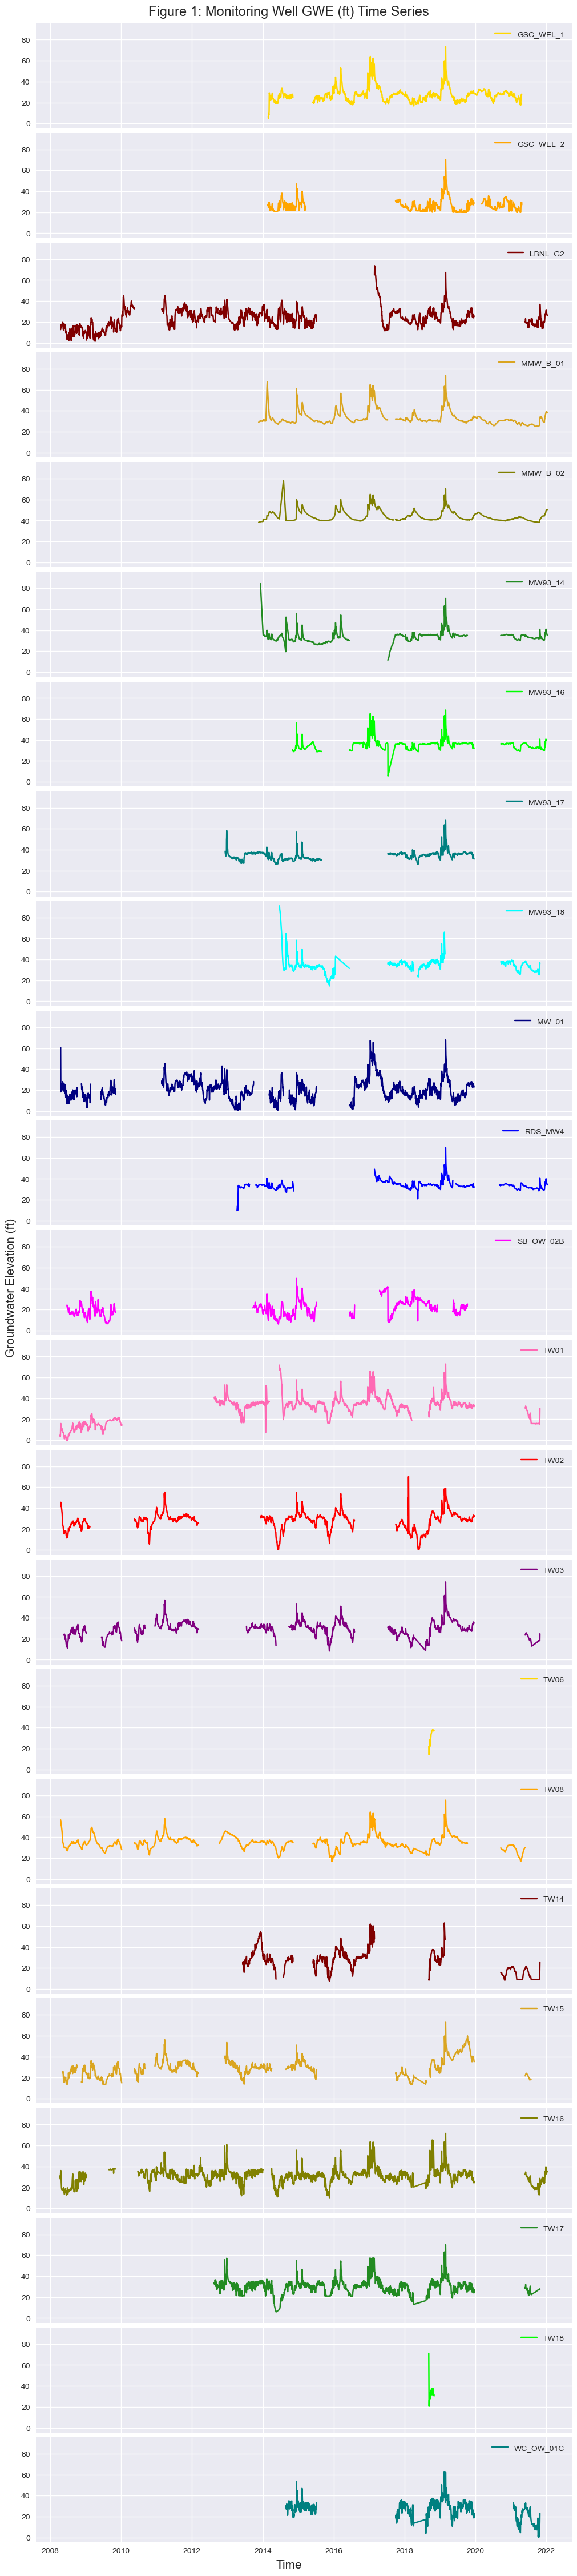

In [13]:
#GWE Plots - Individual GWE timeseries for all GW monitoring wells
colorList = ['gold','orange','maroon','goldenrod','olive','forestgreen','lime','teal','cyan','navy','blue','magenta','hotpink',
            'red','purple']


nrow = len(dfPlotGWE.columns)
fig, axes = plt.subplots(nrow, 1, sharex=True, sharey = True, constrained_layout=True)   
for i, ax in enumerate(fig.axes):
    col = dfPlotGWE.columns[i]
    dfPlotGWE = dfPlotGWE.drop(dfPlotGWE.index[dfPlotGWE[col] < 0])    
    if i >= len(colorList):
        ax.plot(dfPlotGWE.index, dfPlotGWE[col], color = colorList[i-len(colorList)], label = col)
    else:
        ax.plot(dfPlotGWE.index, dfPlotGWE[col], color = colorList[i], label = col)
    ax.legend()
    

fig.supxlabel('Time', fontsize = 15)
fig.supylabel('Groundwater Elevation (ft)', fontsize=15) 
fig.suptitle('Figure 1: Monitoring Well GWE (ft) Time Series', fontsize = 17)
fig.set_figheight(45)
fig.set_figwidth(10)

In [14]:
#GWE Plots #2
#fig, ax = plt.subplots(constrained_layout=True)   
#for i, col in enumerate(dfPlotGWE.columns):
    #dfPlotGWE = dfPlotGWE.drop(dfPlotGWE.index[dfPlotGWE[col] < 0])
    #ax.plot(dfPlotGWE.index, dfPlotGWE[col], color = colorList[i], label = col)
#ax.legend()
#fig.set_figheight(11)
#fig.set_figwidth(15)    

In [15]:
#Caisson Plots - caisson water level is not the same as GWE?
#colorList = ['orange','navy','olive','red']
#fig, ax = plt.subplots(constrained_layout=True)   
#plotCols = ['caisson1Level','caisson2Level','caisson6Level','riverStage']
#dfPlotCassion = dfSCADA[plotCols][((dfSCADA[plotCols]>0)&(dfSCADA[plotCols]<100)).all(1)]
#for i, col in enumerate(plotCols):    
    #ax.plot(dfPlotCassion.index, dfPlotCassion[col], color = colorList[i], label = col)
#fig.legend(loc='lower center', ncol=4 ,bbox_to_anchor=(0.5, -0.05))
#fig.set_figheight(11)
#fig.set_figwidth(15) 

<h4> Figure 2 is a time series of the river stage immediately upstream of the inflatable dam </h4>

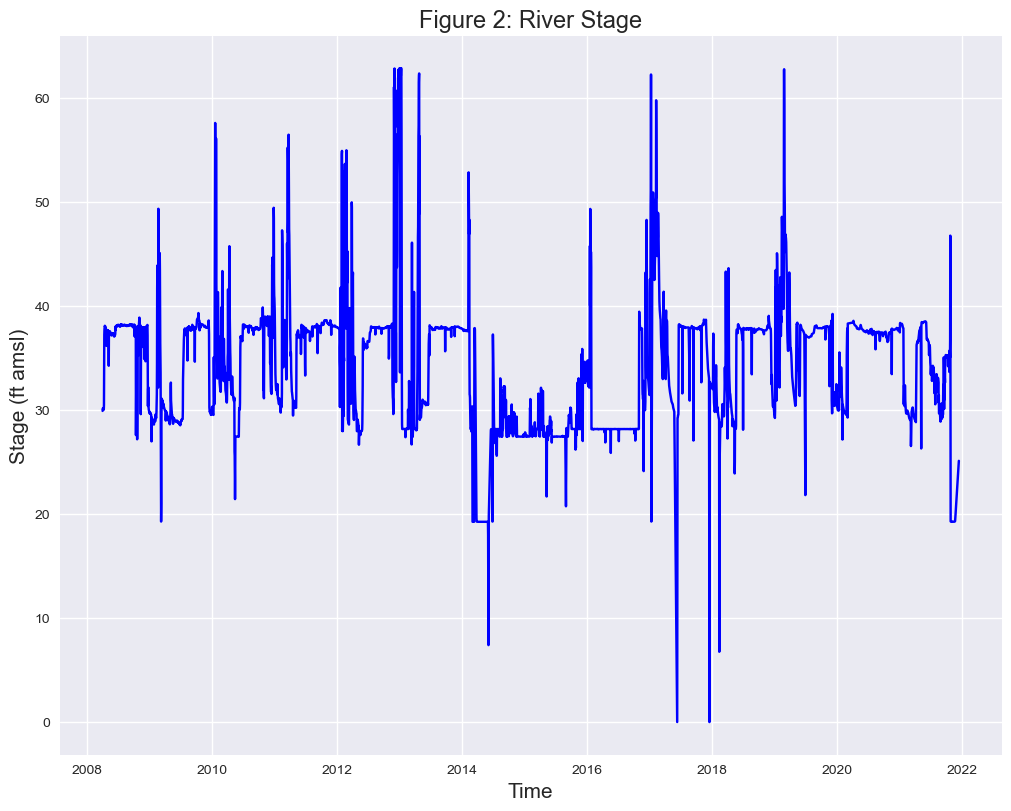

In [16]:
#River Stage Time Series Plot
fig, ax = plt.subplots(constrained_layout=True)   
dfPlotCassion = dfSCADA
dfPlotCassion = dfPlotCassion[dfPlotCassion['riverStage']<100]
#for i, col in enumerate(plotCols):    
ax.plot(dfPlotCassion.index, dfPlotCassion['riverStage'], color = 'blue', label = col)
ax.set_title('Figure 2: River Stage', fontsize = 17)
ax.set_ylabel('Stage (ft amsl)', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
#ax.tick_params(axis='both', labelsize = 12)

#fig.legend(loc='lower center', ncol=4 ,bbox_to_anchor=(0.5, -0.05))
fig.set_figheight(8)
fig.set_figwidth(10) 

In [17]:
#Filter for a specific time period - WY2015 - WY2016
startDate1 = datetime.datetime(2014, 10, 1)
endDate1 = startDate1 + datetime.timedelta(days = 365*2)

dfFilteredPlot = pd.merge(dfAllGWE, dfSCADA, left_index=True, right_index=True, how='outer')
dfFilteredPlot = dfFilteredPlot[(dfFilteredPlot.index>=startDate1) & (dfFilteredPlot.index<=endDate1)]
dfFilteredPlot['caisson1and2Flow'] = dfFilteredPlot['caisson1Flow'] + dfFilteredPlot['caisson2Flow']

In [18]:
#This table shows the number of records available for each well per year. 
dfGWE = dfGWE.sort_values(by=[2014,2015,2016], ascending=False)
plotCols= dfGWE.index[:5].tolist()
plotCols.append('riverStage')

<h4>Because of the data gaps in monitoring well GWE record, it might be worthwhile to look at a few specific periods where the record is more complete. <br>Two separate time periods (WY2015-WY2016 and WY2017-WY2018) were chosen for the detailed analysis below.<br>For each period, the top 5 monitoring wells with the most complete record are chosen to be shown in each figure. </h4>

In [19]:
#Map of wells with Monitoring Well Locations corresponding to WY2015-WY2016 plots

locations = ['TW 17', 'MMW-B-02','MW 93-14','MMW-B-01','TW 02']
dfPlotUpdate1 = dfPlotUpdate[dfPlotUpdate['Well Name'].isin(locations)]

fig = go.Figure()

fig = px.scatter_mapbox(dfPlotUpdate1, lat=dfPlotUpdate1['Latitude'], lon=dfPlotUpdate1['Longitude'], 
                         color = dfPlotUpdate1['Well Name'], 
                        hover_data={'Longitude':False, 'Latitude': False})
fig.update_traces(go.Scattermapbox(
        mode='markers+text',
        marker=go.scattermapbox.Marker(size=10),
        hoverinfo = 'text',
        textfont=dict(size=10),
        textposition = "bottom right"))

fig.add_trace(go.Scattermapbox(
        visible=True,
        lat=dfPlot2['LATITUDE'],
        lon=dfPlot2['LONGITUDE'],
        mode='markers+text',
        marker=go.scattermapbox.Marker(size=15,color='black', opacity=0.4),
        name = 'Cassions',
        hoverinfo = 'text',
        text=dfPlot2['NAME'],
        textposition = "bottom right"))

fig.update_layout(
    margin=dict(l=0, t=30, r=0, b=0, pad=0),
    autosize=False,
    title = 'Map displaying the monitoring wells being plotted in Figure 3 and Figure 4.',
    width = 950,
    height = 800,
    mapbox_style='open-street-map',
    mapbox=dict(center=dict(lat=38.506,lon=-122.887), zoom=13.5))

fig.show()

<h4> Figure 3 and Figure 4 compare groundwater elevation with surface water elevation for WY 2015 and WY 2016. <br>Daily pumping volume is also plotted on the same figures.</h4>

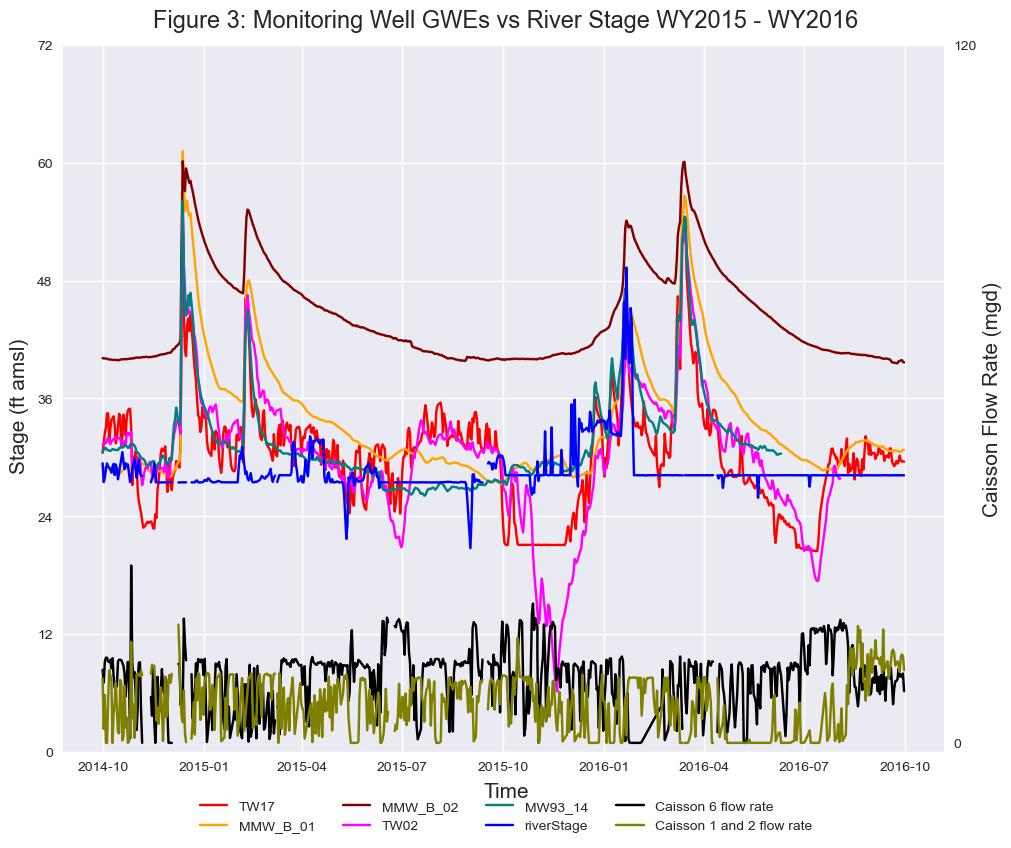

In [20]:
#Plot GWE against River Stage for period WY2015 - WY2016
#Top 5 wells with the most complete records are chosen for this period
colorList = ['red','orange','maroon','magenta','teal','blue','forestgreen','lime','teal','cyan','navy','olive','magenta',
             'hotpink','gold','purple']   

fig, ax = plt.subplots(constrained_layout=True)   

for i, col in enumerate(plotCols):    
    ax.plot(dfFilteredPlot.index, dfFilteredPlot[col], color = colorList[i], label = col)
    
ax.set_yticks(np.linspace(0,72,7))
ay = ax.twinx()
ay.plot(dfFilteredPlot.index, dfFilteredPlot['caisson6Flow'], color = 'black', label = 'Caisson 6 flow rate')
ay.plot(dfFilteredPlot.index, dfFilteredPlot['caisson1and2Flow'], color = 'olive', label = 'Caisson 1 and 2 flow rate')
ay.set_yticks(np.linspace(0,120,2))
ay.grid(False)
ay.set_ylabel('Caisson Flow Rate (mgd)', fontsize=15)
    
#ax.tick_params(axis='both', labelsize = 12)    
fig.legend(loc='lower center', ncol=4 ,bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Figure 3: Monitoring Well GWEs vs River Stage WY2015 - WY2016', fontsize = 17)
fig.supxlabel('Time', fontsize = 15)
fig.supylabel('Stage (ft amsl)', fontsize=15) 
fig.set_figheight(8)
fig.set_figwidth(10) 

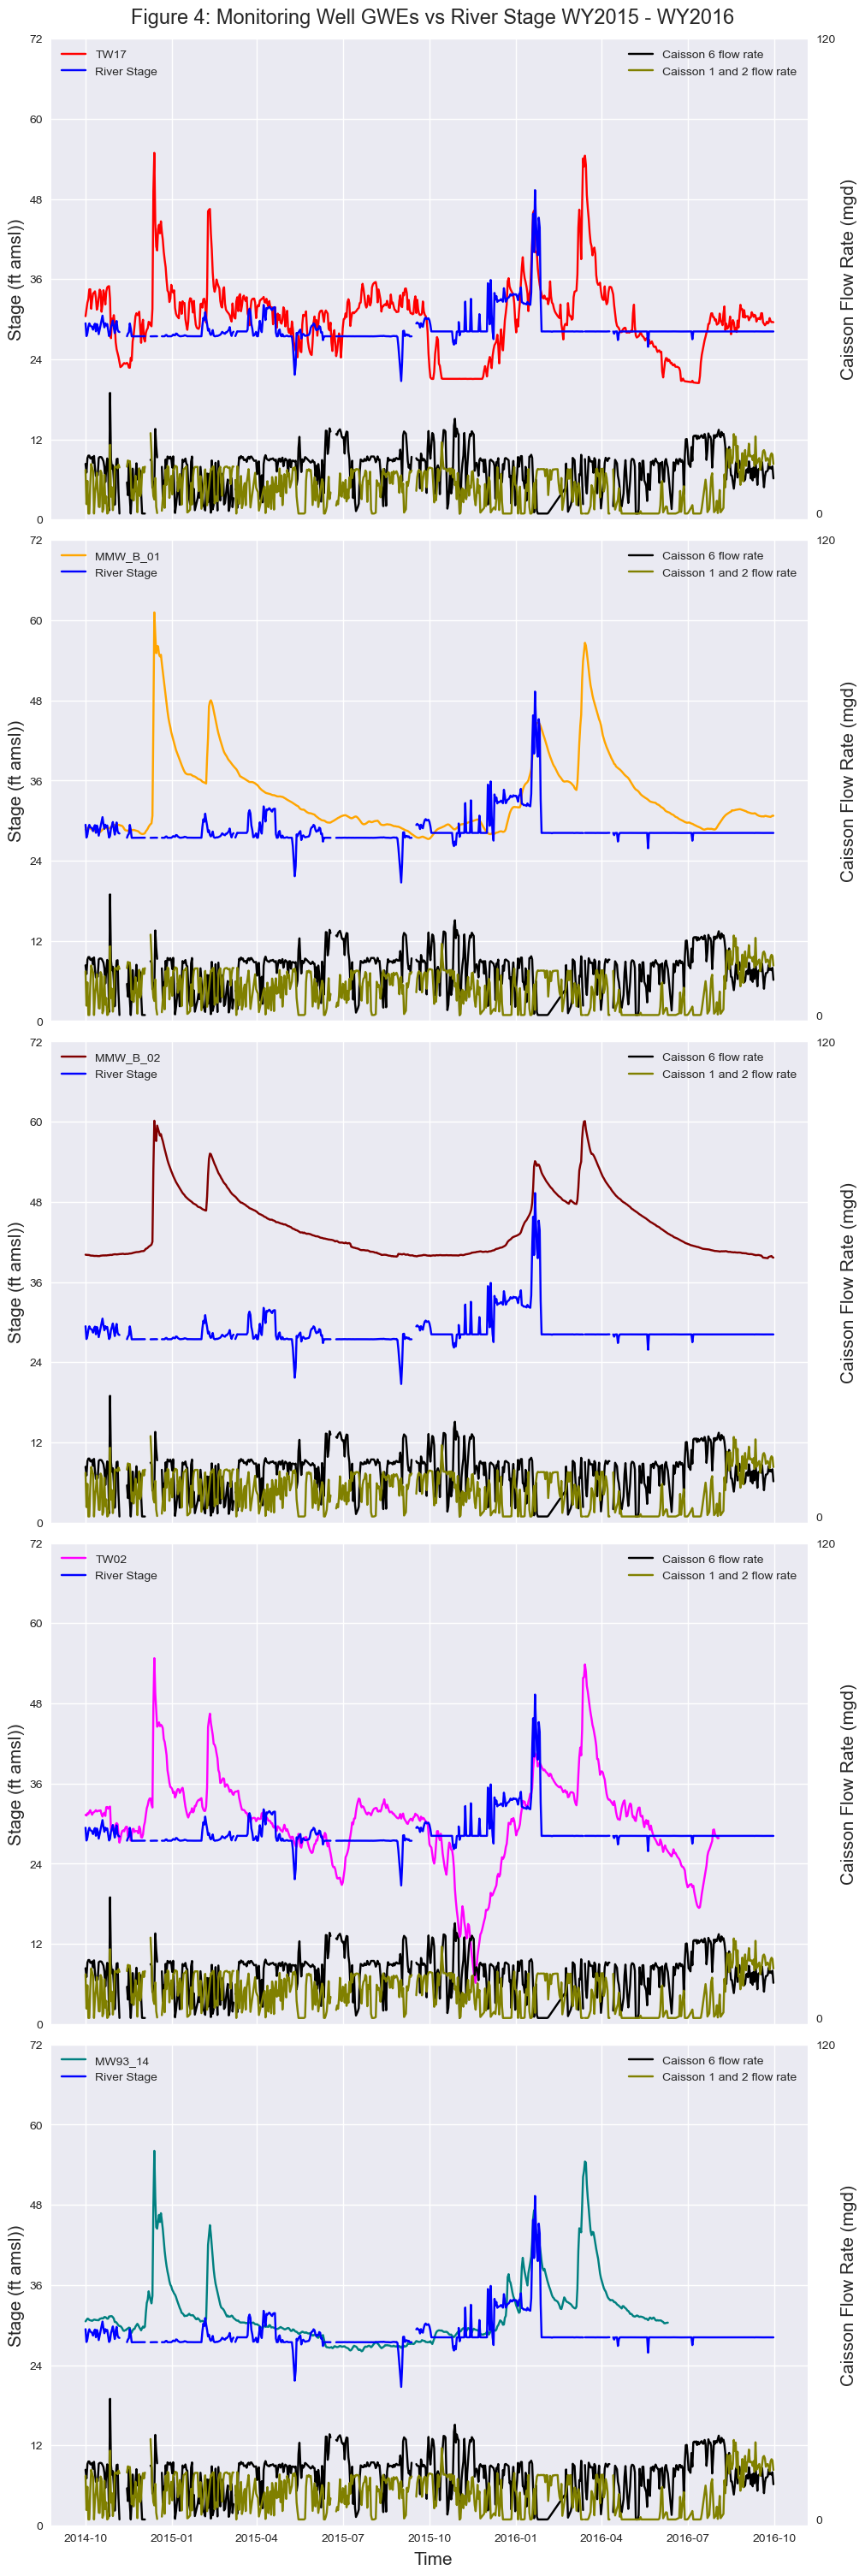

In [21]:
#Plot GWE against River Stage for period WY2015 - WY2016
#Top 5 wells with the most complete records are chosen for this period
nrow = len(plotCols) - 1
fig, axes = plt.subplots(nrow, 1, sharex=True, sharey = True, constrained_layout=True)   
for i, ax in enumerate(fig.axes):
    col = plotCols[i]   
    ax.plot(dfFilteredPlot.index, dfFilteredPlot[col], color = colorList[i], label = col)
    ax.plot(dfFilteredPlot.index, dfFilteredPlot['riverStage'], color = 'blue' , label = 'River Stage')
    ax.legend(loc=2)

    ax.set_yticks(np.linspace(0,72,7))
    ax.set_ylabel('Stage (ft amsl))', fontsize=15) 
    ay = ax.twinx()
    ay.plot(dfFilteredPlot.index, dfFilteredPlot['caisson6Flow'], color = 'black', label = 'Caisson 6 flow rate')
    ay.plot(dfFilteredPlot.index, dfFilteredPlot['caisson1and2Flow'], color = 'olive', label = 'Caisson 1 and 2 flow rate')
    ay.set_yticks(np.linspace(0,120,2))
    ay.grid(False)
    ay.set_ylabel('Caisson Flow Rate (mgd)', fontsize=15)
    ay.legend(loc=0)

 

fig.supxlabel('Time', fontsize = 15)
fig.suptitle('Figure 4: Monitoring Well GWEs vs River Stage WY2015 - WY2016', fontsize = 17)
fig.set_figheight(30)
fig.set_figwidth(10)

<h4> Figure 5 and Figure 6 compare groundwater elevation with surface water elevation for WY 2015 and WY 2016. <br>Daily pumping volume is also plotted on the same figures.</h4>

In [22]:
#Filter for a specific time period - WY2017 - WY2018
startDate2 = datetime.datetime(2016, 10, 1)
endDate2 = startDate2 + datetime.timedelta(days = 365*2)

dfFilteredPlot = pd.merge(dfAllGWE, dfSCADA, left_index=True, right_index=True, how='outer')
dfFilteredPlot = dfFilteredPlot[(dfFilteredPlot.index>=startDate2) & (dfFilteredPlot.index<=endDate2)]
dfFilteredPlot['caisson1and2Flow'] = dfFilteredPlot['caisson1Flow'] + dfFilteredPlot['caisson2Flow']

for col in dfFilteredPlot.columns:
    dfFilteredPlot = dfFilteredPlot.drop(dfFilteredPlot[(dfFilteredPlot[col]>100) | (dfFilteredPlot[col]<=0)].index)
    
dateStart = dfFilteredPlot.index[0]
dateEnd = dfFilteredPlot.index[len(dfFilteredPlot)-1]
dfDates = pd.DataFrame({'date':pd.date_range(start=dateStart, end=dateEnd)})
dfDates = dfDates.set_index('date')
dfFilteredPlot = pd.merge(dfDates, dfFilteredPlot, left_index=True, right_index=True, how='left')

In [23]:
#This table shows the number of records available for each well per year. 
dfGWE = dfGWE.sort_values(by=[2016,2017,2018], ascending=False)
plotCols= dfGWE.index[1:6].tolist()
plotCols.append('riverStage')

In [24]:
#Map of wells with Monitoring Well Locations corresponding to WY2017-WY2018 plots

locations = ['TW 17', 'TW 08','MMW-B-02','TW 16','TW 01']
dfPlotUpdate1 = dfPlotUpdate[dfPlotUpdate['Well Name'].isin(locations)]

fig = go.Figure()

fig = px.scatter_mapbox(dfPlotUpdate1, lat=dfPlotUpdate1['Latitude'], lon=dfPlotUpdate1['Longitude'], 
                         color = dfPlotUpdate1['Well Name'], 
                        hover_data={'Longitude':False, 'Latitude': False})
fig.update_traces(go.Scattermapbox(
        mode='markers+text',
        marker=go.scattermapbox.Marker(size=10),
        hoverinfo = 'text',
        textfont=dict(size=10),
        textposition = "bottom right"))

fig.add_trace(go.Scattermapbox(
        visible=True,
        lat=dfPlot2['LATITUDE'],
        lon=dfPlot2['LONGITUDE'],
        mode='markers+text',
        marker=go.scattermapbox.Marker(size=15,color='black', opacity=0.4),
        name = 'Cassions',
        hoverinfo = 'text',
        text=dfPlot2['NAME'],
        textposition = "bottom right"))

fig.update_layout(
    margin=dict(l=0, t=30, r=0, b=0, pad=0),
    autosize=False,
    title = 'Map displaying the monitoring wells being plotted in Figure 5 and Figure 6.',
    width = 950,
    height = 800,
    mapbox_style='open-street-map',
    mapbox=dict(center=dict(lat=38.506,lon=-122.887), zoom=13.5))

fig.show()

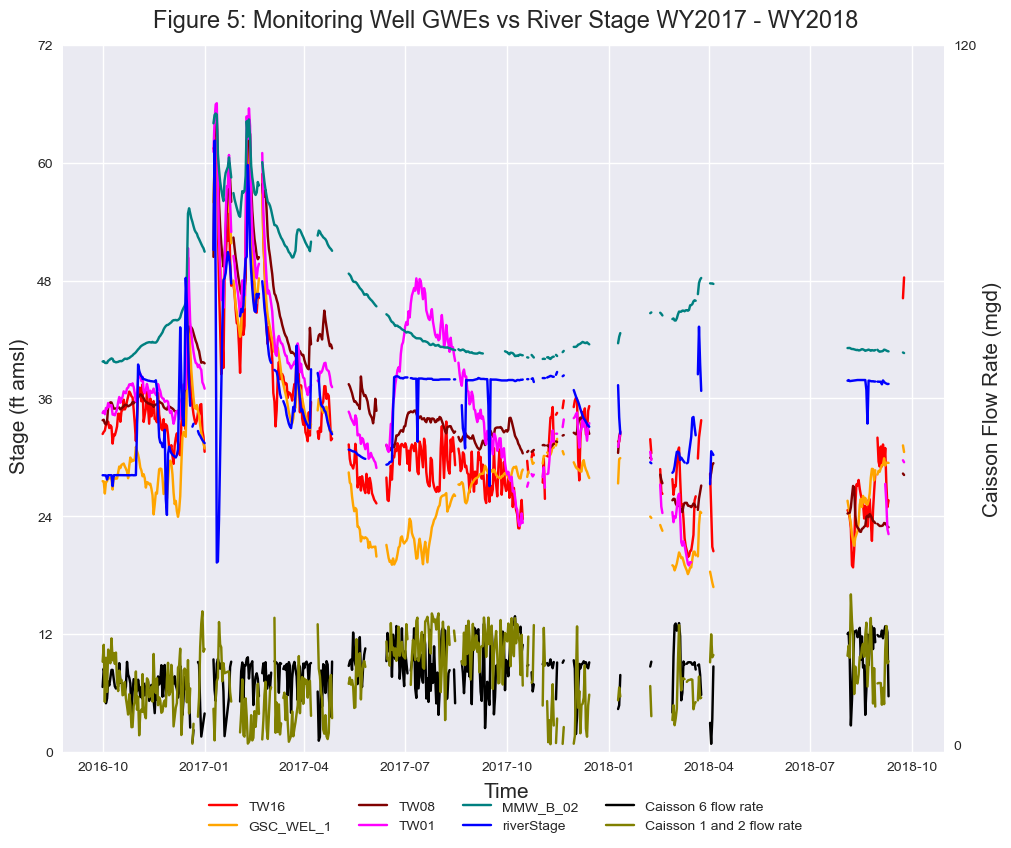

In [25]:
#Plot GWE against River Stage for period WY2017 - WY2018
#Top 5 wells with the most complete records are chosen for this period
colorList = ['red','orange','maroon','magenta','teal','blue','forestgreen','lime','teal','cyan','navy','olive','magenta',
             'hotpink','gold','purple']   

fig, ax = plt.subplots(constrained_layout=True)   

for i, col in enumerate(plotCols):    
    ax.plot(dfFilteredPlot.index, dfFilteredPlot[col], color = colorList[i], label = col)
    
ax.set_yticks(np.linspace(0,72,7))
ay = ax.twinx()
ay.plot(dfFilteredPlot.index, dfFilteredPlot['caisson6Flow'], color = 'black', label = 'Caisson 6 flow rate')
ay.plot(dfFilteredPlot.index, dfFilteredPlot['caisson1and2Flow'], color = 'olive', label = 'Caisson 1 and 2 flow rate')
ay.set_yticks(np.linspace(0,120,2))
ay.grid(False)
ay.set_ylabel('Caisson Flow Rate (mgd)', fontsize=15)
    
#ax.tick_params(axis='both', labelsize = 12)    
fig.legend(loc='lower center', ncol=4 ,bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Figure 5: Monitoring Well GWEs vs River Stage WY2017 - WY2018', fontsize = 17)
fig.supxlabel('Time', fontsize = 15)
fig.supylabel('Stage (ft amsl)', fontsize=15) 
fig.set_figheight(8)
fig.set_figwidth(10) 

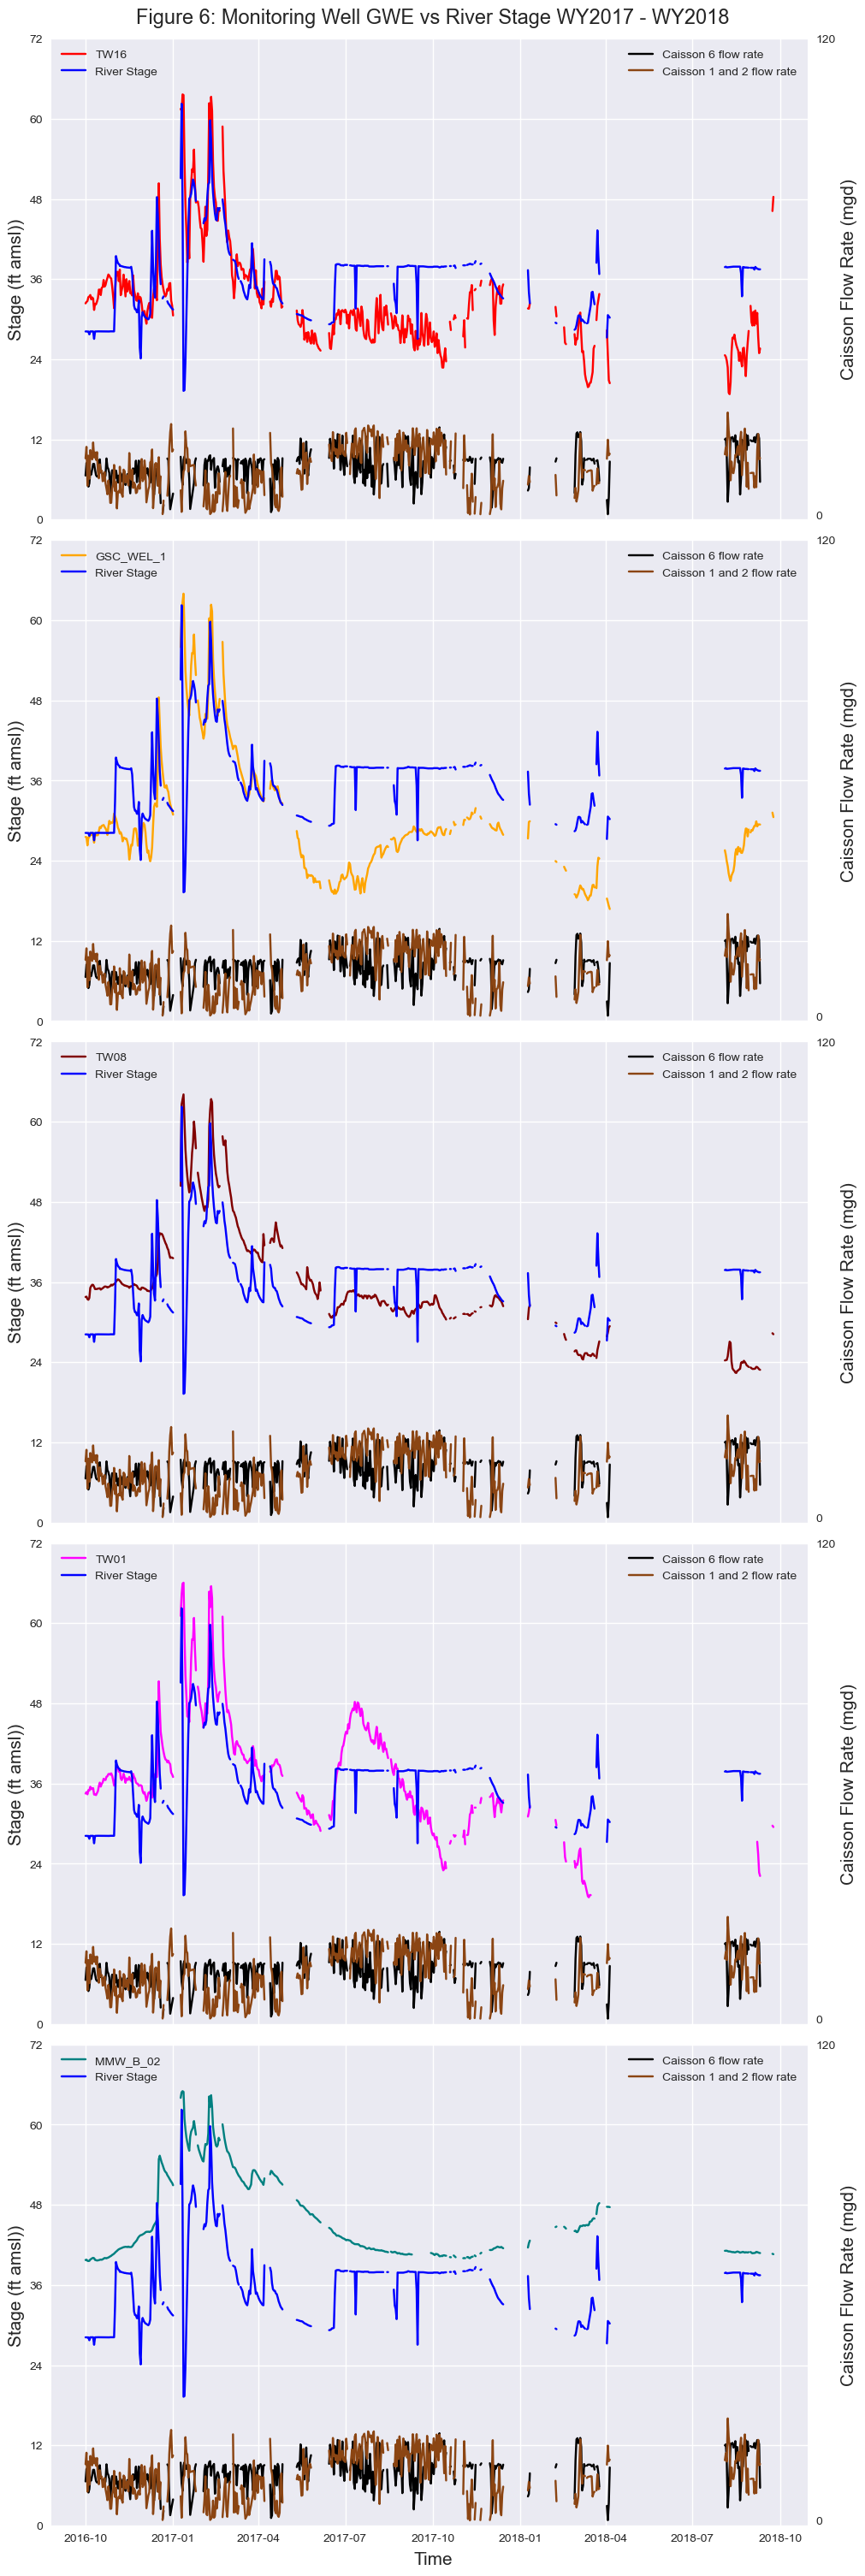

In [26]:
#Plot GWE against River Stage for period WY2017 - WY2018
#Top 5 wells with the most complete records are chosen for this period
nrow = len(plotCols) - 1
fig, axes = plt.subplots(nrow, 1, sharex=True, sharey = True, constrained_layout=True)   
for i, ax in enumerate(fig.axes):
    col = plotCols[i]
    #dfPlotGWE = dfPlotGWE.drop(dfPlotGWE.index[dfPlotGWE[col] < 0])    
    ax.plot(dfFilteredPlot.index, dfFilteredPlot[col], color = colorList[i], label = col)
    ax.plot(dfFilteredPlot.index, dfFilteredPlot['riverStage'], color = 'blue' , label = 'River Stage')
    ax.legend(loc=2)

    ax.set_yticks(np.linspace(0,72,7))
    ax.set_ylabel('Stage (ft amsl))', fontsize=15) 
    ay = ax.twinx()
    ay.plot(dfFilteredPlot.index, dfFilteredPlot['caisson6Flow'], color = 'black', label = 'Caisson 6 flow rate')
    ay.plot(dfFilteredPlot.index, dfFilteredPlot['caisson1and2Flow'], color = 'saddlebrown', label = 'Caisson 1 and 2 flow rate')
    ay.set_yticks(np.linspace(0,120,2))
    ay.grid(False)
    ay.set_ylabel('Caisson Flow Rate (mgd)', fontsize=15)
    ay.legend(loc=0)

 

fig.supxlabel('Time', fontsize = 15)
fig.suptitle('Figure 6: Monitoring Well GWE vs River Stage WY2017 - WY2018', fontsize = 17)
fig.set_figheight(30)
fig.set_figwidth(10)